In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt


from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

$$ n =\frac{\rho}{m_n} = \frac{2p_F^3}{3\pi^2\hbar^3} \iff x_F = \frac{p_F}{m_n c}\iff \frac{\rho}{m_n} =\frac{2}{3\pi^2} \left(\frac{ m_n c}{\hbar}\right)^3x_F^3 $$ 
$$ 1-x_\sigma - A_\sigma^2 \frac{2}{\pi^2 } \int_0^{x_F(n)} \frac{ x_\sigma}{\sqrt{x^2 + x_\sigma^2}} x^2 dx = 0$$
con
$$x_\sigma= 1- \frac{g_\sigma \sigma}{m_n} \qquad ; \quad A_\sigma=\frac{g_\sigma m_n}{m_\sigma}$$

In [22]:
#hbar_MKS = 1.0545718e-34 # J s
#c_MKS = 299792458 # m/s
#G_MKS = 6.67430e-11 # m^3/kg/s^2
#pi = np.pi
#m_nuc_MKS = 1.6726219e-27 # kg

c    = 2.99792458e10
G    = 6.67e-8
mn   = 1.674e-24
hbar = 1.05457162e-27
fm   = 1e-13

mn_a = mn*c/hbar
# Definimos las constantes necesarias en unidades geometrizadas
#hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
#m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes (valores tomados del paper de Walecka)
#A_sigma = np.sqrt(266.9*hbar/m_nuc**2)
#A_omega = np.sqrt(195.7*hbar/m_nuc**2)


def autoconsistencia(x_s, A_s, rho_):
    n_ = rho_ / mn
    x_f = (1.0/mn_a)*(3.0*np.pi**2*n_/2.0)**(1/3) # Momento de Fermi en función de n_barion
    # La integral es analítica
    integral = x_s * ( x_f * np.sqrt( x_s**2 + x_f**2 ) - x_s**2 * np.arctanh( x_f/np.sqrt(x_s**2+x_f**2) ) )
    return 1.0 - x_s - A_s * integral / ( np.pi**2 )

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def solucion_x_sigma(rho_b, A_sigma):
    return fsolve(autoconsistencia, 1, args=(A_sigma, rho_b))[0]


def Int(x,a):
    ff  = x**2 + a**2
    f12 = np.sqrt(ff)
    AAe = x * (2.0*x**2 + a**2) * f12 - a**4*np.arctanh( x / f12 ) 
    AAp = x * f12 * (2.0*x**2 - 3.0*a**2) + 3.0 * a**4*np.arctanh( x / f12 ) 
    
    return [ AAe/8.0, AAp/8.0 ]

def EoS(rho_, A_s, A_w):
    n_ = rho_ / mn
    x_f = (1.0/mn_a)*(3.0*np.pi**2*n_/2.0)**(1/3) # Momento de Fermi en función de n_barion
    
    x_s= fsolve(autoconsistencia, 1, args=(A_s, rho_))[0]

    Ints = Int(x_f, x_s)

    den_ = 0.5 * ( 1.0 - x_s )**2 / A_s + 2.0 * A_w * x_f**6 / (9.0*np.pi**4)  + 2.0*Ints[0] / np.pi**2

    p_   = -0.5 * (1.0-x_s)**2 / A_s + 2.0 * A_w * x_f**6 / (9.0*np.pi**4)  + 2.0*Ints[1] /  (3.0 * np.pi**2)


    return [ n_, den_, p_]

In [11]:
(1.0/mn_a)*(3.0*np.pi**2*1e10/mn/2.0)**(1/3)

0.009362211328711874

In [13]:
xx = np.arange(10,17,0.1)
xxs = np.zeros(len(xx))

for i,x in enumerate(xx):
    xxs[i] = solucion_x_sigma(np.power(10.0,x), 266.9)

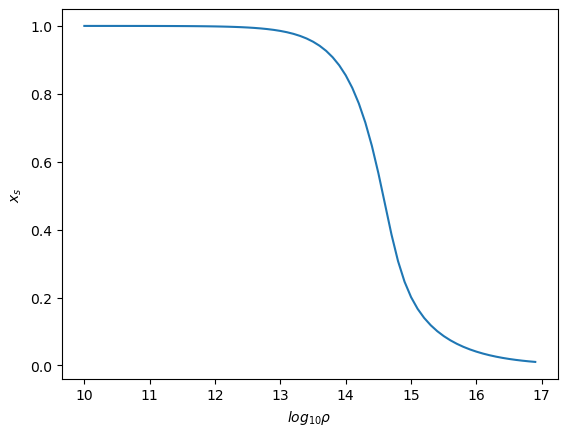

In [14]:
plt.plot(xx, xxs)
plt.xlabel(r'$log_{10} \rho$')
plt.ylabel(r'$x_s$')
plt.show()

In [56]:
xx = np.arange(10,17,0.035)
eos_ = np.zeros((3,len(xx)))

for i,x in enumerate(xx):
    eos_[:,i] = EoS(np.power(10.0,x), 266.9,195.7)

In [19]:
e_dim = mn**4*(c/hbar)**3

Text(0, 0.5, '$p$')

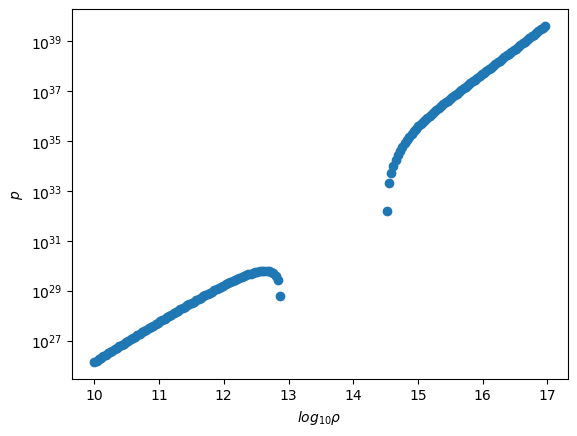

In [57]:
plt.semilogy(xx, eos_[2,:]*e_dim*c**2, "o" )
plt.xlabel(r'$log_{10} \rho$')
plt.ylabel(r'$p$')


Text(0.5, 0, '$e$')

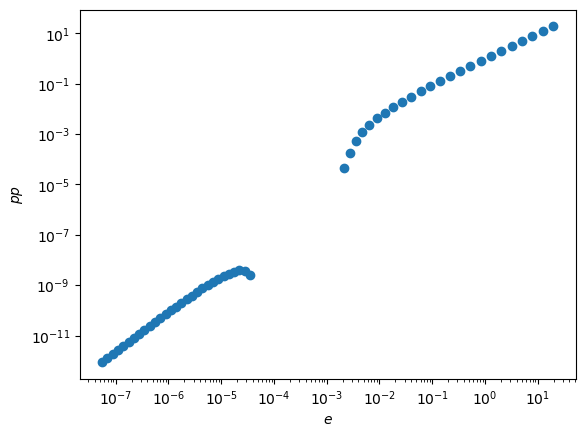

In [ ]:
plt.loglog(eos_[1,:]*e_dim*c**2 , eos_[2,:]*e_dim*c**2, "o" )
plt.ylabel(r'$pp$')
plt.xlabel(r'$e$')

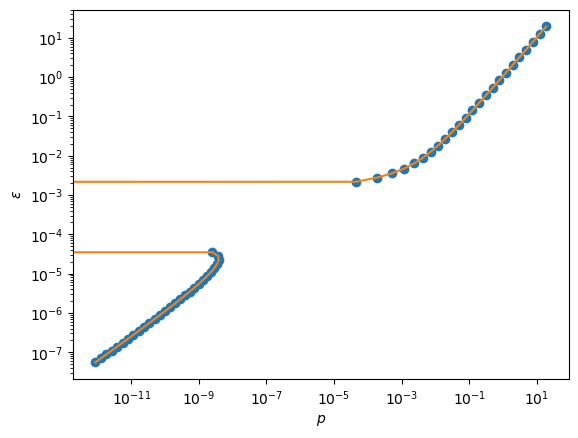

In [38]:
# Realizamos una interpolación para obtener la función de energía en función de la presión
p_e = interp1d(eos_[2,:], eos_[1,:], kind='cubic')

# Graficamos la función de energía en función de la presión
plt.plot(eos_[2,:], eos_[1,:], "o" )
plt.loglog(eos_[2,:], p_e(eos_[2,:]) )
plt.xlabel(r'$p$')
plt.ylabel(r'$\epsilon$')
plt.show()
